In [1]:
# Importing all the libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import csv

# Machine Learning models
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score, 
    matthews_corrcoef
)

C:\Users\chand\Py_Env\ckd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading the training data and labels
train_data = pd.read_csv("proData/train_data.csv")
train_labels = pd.read_csv("proData/train_labels.csv")
test_data = pd.read_csv("proData/test_data.csv")
test_labels = pd.read_csv("proData/test_labels.csv")

In [3]:
print(train_data.head())
print("\n")
print(train_data.shape)
print("\n")
print(train_data.dtypes)

        age        bp        sg       bgr        bu        sc       sod  \
0 -2.781611  0.389606  0.255582 -0.572666 -0.656520 -0.362946 -0.046898   
1  1.095402 -0.385797  0.255582 -0.587083  0.890195  0.392960 -0.385466   
2  0.913667 -0.385797 -0.700480  2.426105 -0.533765 -0.192867 -0.046898   
3  0.307884  0.389606  0.255582  0.018438 -0.018193 -0.381844  1.307375   
4  1.216559  0.389606  0.255582 -0.933095 -0.214601 -0.381844  0.517383   

        pot      hemo       pcv   pc  pcc   ba  htn   dm  cad  appet   pe  ane  
0 -0.027990 -0.398049 -0.819699  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
1 -0.479221 -1.231920 -0.064937  0.0  0.0  0.0  1.0  1.0  1.0    0.0  1.0  0.0  
2 -0.027990 -0.777081 -0.190731  0.0  1.0  0.0  1.0  1.0  0.0    1.0  0.0  0.0  
3  0.197625  1.004371  0.815619  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
4  0.017133  0.776951  0.941412  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  


(398, 19)


age      float64
bp       float64
sg       float6

In [4]:
print(train_labels.head())
print("\n")
print(train_labels.shape)
print("\n")
print(train_labels.dtypes)

   class
0    1.0
1    1.0
2    1.0
3    0.0
4    0.0


(398, 1)


class    float64
dtype: object


In [5]:
train_labels = train_labels['class'].values

In [6]:
numerical_vars = ['age', 'bp', 'sg', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv']
categorical_vars = ['pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

In [7]:
# Creating numerical and categorical datasets again
numerical_df_train = train_data[numerical_vars]
categorical_df_train = train_data[categorical_vars]

numerical_df_test = test_data[numerical_vars]
categorical_df_test = test_data[categorical_vars]

In [8]:
# Finding the correlation between numeric data and dependent feature
numeric_dict = {}
for fea in numerical_vars:
    corr, _ = pointbiserialr(train_labels, numerical_df_train[fea])
    
    # Determine the direction of the association
    if corr > 0:
        direction = "Positive association"
    elif corr < 0:
        direction = "Negative association"
    else:
        direction = "No association"
    
    # Determine the strength of the association
    abs_corr = abs(corr)
    if abs_corr < 0.1:
        strength = "Weak"
    elif abs_corr < 0.3:
        strength = "Moderate"
    else:
        strength = "Strong"
    
    numeric_dict[fea] = {
        'correlation': corr,
        'direction': direction,
        'strength': strength
    }

In [9]:
print(numeric_dict)

{'age': {'correlation': 0.23543342477093454, 'direction': 'Positive association', 'strength': 'Moderate'}, 'bp': {'correlation': 0.30777977787428756, 'direction': 'Positive association', 'strength': 'Strong'}, 'sg': {'correlation': -0.6956760463047138, 'direction': 'Negative association', 'strength': 'Strong'}, 'bgr': {'correlation': 0.42726247670428513, 'direction': 'Positive association', 'strength': 'Strong'}, 'bu': {'correlation': 0.42498382920341843, 'direction': 'Positive association', 'strength': 'Strong'}, 'sc': {'correlation': 0.3121937428518239, 'direction': 'Positive association', 'strength': 'Strong'}, 'sod': {'correlation': -0.3551252085595638, 'direction': 'Negative association', 'strength': 'Strong'}, 'pot': {'correlation': 0.04411633788376975, 'direction': 'Positive association', 'strength': 'Weak'}, 'hemo': {'correlation': -0.7607961667458085, 'direction': 'Negative association', 'strength': 'Strong'}, 'pcv': {'correlation': -0.7090764225117683, 'direction': 'Negative 

In [10]:
# Finding the correlation between categorical data and dependent feature
categorical_dict = {}
for _, fea in enumerate(categorical_df_train):
    cont_table = np.array(pd.crosstab(train_labels, categorical_df_train[fea], rownames=None,colnames=None))
    chi2, pval, dof, expected = chi2_contingency(cont_table)

    observed_proportions = cont_table / np.sum(cont_table)
    expected_proportions = expected / np.sum(expected)

    # Check conditions for positive, negative, or no association
    if observed_proportions[0, 0] > expected_proportions[0, 0] and observed_proportions[1, 1] > expected_proportions[1, 1]:
        direction = "Positive association"
    elif observed_proportions[0, 1] > expected_proportions[0, 1] and observed_proportions[1, 0] > expected_proportions[1, 0]:
        direction = "Negative association"
    else:
        direction = "No association"
    
    # Calculate Cramer's V
    obs = np.sum(cont_table)
    minDim = min(cont_table.shape) - 1
    V = np.sqrt(chi2 / (obs * minDim))
    
    # Determine the strength of the association
    if V < 0.1:
        strength = "Weak"
    elif V < 0.3:
        strength = "Moderate"
    else:
        strength = "Strong"
    
    categorical_dict[fea] = {
        'chi2': chi2,
        'pval': pval,
        'dof': dof,
        'expected': expected,
        'cramers_v': V,
        'direction': direction,
        'strength': strength
    }

In [11]:
print(categorical_dict)

{'pc': {'chi2': 71.09053379416282, 'pval': 3.412032229957074e-17, 'dof': 1, 'expected': array([[168.,  31.],
       [168.,  31.]]), 'cramers_v': 0.4226339215486911, 'direction': 'Positive association', 'strength': 'Strong'}, 'pcc': {'chi2': 31.484574140810405, 'pval': 2.0103098353569095e-08, 'dof': 1, 'expected': array([[183.5,  15.5],
       [183.5,  15.5]]), 'cramers_v': 0.28125961352999335, 'direction': 'Positive association', 'strength': 'Moderate'}, 'ba': {'chi2': 13.578416013925152, 'pval': 0.00022880122670809844, 'dof': 1, 'expected': array([[191.5,   7.5],
       [191.5,   7.5]]), 'cramers_v': 0.1847068573458108, 'direction': 'Positive association', 'strength': 'Moderate'}, 'htn': {'chi2': 162.8946680049883, 'pval': 2.6377432953903193e-37, 'dof': 1, 'expected': array([[140.5,  58.5],
       [140.5,  58.5]]), 'cramers_v': 0.6397523625901425, 'direction': 'Positive association', 'strength': 'Strong'}, 'dm': {'chi2': 153.08934815184816, 'pval': 3.662233533072857e-35, 'dof': 1, 'ex

In [12]:
results = []

# Iterate over numerical features
for fea, corr_data in numeric_dict.items():
    results.append([fea, 'Numeric', 'pointbiserialr', corr_data['correlation'], corr_data['direction'], corr_data['strength']])

# Iterate over categorical features
for fea, corr_data in categorical_dict.items():
    results.append([fea, 'Categorical', 'Chi Square test with Cramers V', corr_data['cramers_v'], corr_data['direction'], corr_data['strength']])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Feature', 'Type', 'Correlation Type', 'Value', 'Direction', 'Strength'])

In [13]:
output_dir = 'features'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save results to CSV
results_df.to_csv('features/correlation_results.csv', index=False)

In [14]:
# Initialize lists to store selected features
selected_features = {
    'Positive': [],
    'Negative': []
}

# Iterate over categorical features for Categorical associations
for fea, corr_data in categorical_dict.items():
    if corr_data['strength'] in ['Moderate', 'Strong']:
        if corr_data['direction'] == 'Positive association':
            selected_features['Positive'].append((fea, corr_data['cramers_v']))
        elif corr_data['direction'] == 'Negative association':
            selected_features['Negative'].append((fea, corr_data['cramers_v']))

# Iterate over numerical features for Numeric associations
for fea, corr_data in numeric_dict.items():
    if corr_data['strength'] in ['Moderate', 'Strong']:
        if corr_data['direction'] == 'Positive association':
            selected_features['Positive'].append((fea, corr_data['correlation']))
        elif corr_data['direction'] == 'Negative association':
            selected_features['Negative'].append((fea, corr_data['correlation']))

# Sort selected features by association strength
selected_features['Positive'].sort(key=lambda x: x[1], reverse=True)
selected_features['Negative'].sort(key=lambda x: x[1], reverse=True)

# Initialize final lists for top 10 features
top_features = []
used_features = set()  # To track used features

# Choose top 10 features each for positive and negative associations
count_positive = min(5, len(selected_features['Positive']))
count_negative = min(5, len(selected_features['Negative']))

# Add top positive features
for fea, value in selected_features['Positive'][:count_positive]:
    if fea not in used_features:
        top_features.append((fea, 'Positive', value))
        used_features.add(fea)

# Add top negative features
for fea, value in selected_features['Negative'][:count_negative]:
    if fea not in used_features:
        top_features.append((fea, 'Negative', value))
        used_features.add(fea)

# If one side has fewer than 5 features, add more from the opposite side to make it 6
if len(top_features) < 10:
    remaining_needed = 10 - len(top_features)

    # Add additional positive features
    additional_positive = [(fea, 'Positive', value) for fea, value in selected_features['Positive'] if fea not in used_features][:remaining_needed]
    top_features.extend(additional_positive)
    used_features.update([fea for fea, _, _ in additional_positive])

    # Add additional negative features if still needed
    if len(top_features) < 10:
        additional_negative = [(fea, 'Negative', value) for fea, value in selected_features['Negative'] if fea not in used_features][:remaining_needed]
        top_features.extend(additional_negative)

# Convert to DataFrame
df = pd.DataFrame(top_features, columns=['Feature', 'Association', 'Strength'])

# Display or further process the top_features_df DataFrame
print(df)

  Feature Association  Strength
0     htn    Positive  0.639752
1      dm    Positive  0.620199
2     bgr    Positive  0.427262
3      bu    Positive  0.424984
4      pc    Positive  0.422634
5   appet    Negative  0.435012
6     sod    Negative -0.355125
7      sg    Negative -0.695676
8     pcv    Negative -0.709076
9    hemo    Negative -0.760796


In [15]:
df.to_csv('features/selected_features.csv', index=False)

In [16]:
# Extract column names from the first dataset
column_names = train_data.columns

# Ensure the first column of df2 contains the row names that correspond to df1's columns
df_first_column = df.iloc[:, 0]

# Filter df2 to only include rows where the first column matches column names of df1
df_filtered = df[df_first_column.isin(column_names)]

# Reorder the rows in df2_filtered based on the order of df1's columns
df = df_filtered.set_index(df_first_column).reindex(column_names).dropna().reset_index()

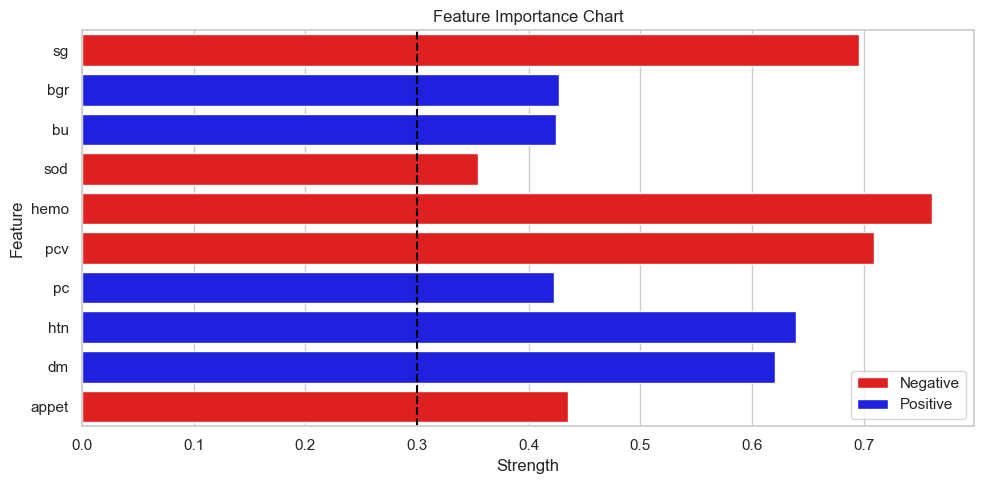

In [17]:
# Create a bar plot
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

df['Strength'] = df['Strength'].abs()

# Define barplot with hue for different colors for positive and negative associations
barplot = sns.barplot(x='Strength', y='Feature', hue='Association', data=df, palette={'Positive': 'blue', 'Negative': 'red'})

# Add vertical lines at -0.3 and 0.3
plt.axvline(x=0.3, color='black', linestyle='--')

# Add title and labels
plt.title('Feature Importance Chart')
plt.xlabel('Strength')
plt.ylabel('Feature')

# Adjust the legend
plt.legend(loc='lower right')

# Show plot
plt.tight_layout()
plt.show()

In [18]:
# Normalizing numerical data
scaler = StandardScaler()
normalized_df_train = pd.DataFrame(scaler.fit_transform(numerical_df_train), columns=numerical_df_train.columns)
normalized_df_test = pd.DataFrame(scaler.transform(numerical_df_test), columns=numerical_df_test.columns)

In [19]:
print(normalized_df_train.head())
print(normalized_df_test.head())

        age        bp        sg       bgr        bu        sc       sod  \
0 -2.781611  0.389606  0.255582 -0.572666 -0.656520 -0.362946 -0.046898   
1  1.095402 -0.385797  0.255582 -0.587083  0.890195  0.392960 -0.385466   
2  0.913667 -0.385797 -0.700480  2.426105 -0.533765 -0.192867 -0.046898   
3  0.307884  0.389606  0.255582  0.018438 -0.018193 -0.381844  1.307375   
4  1.216559  0.389606  0.255582 -0.933095 -0.214601 -0.381844  0.517383   

        pot      hemo       pcv  
0 -0.027990 -0.398049 -0.819699  
1 -0.479221 -1.231920 -0.064937  
2 -0.027990 -0.777081 -0.190731  
3  0.197625  1.004371  0.815619  
4  0.017133  0.776951  0.941412  
        age        bp        sg       bgr        bu        sc       sod  \
0  1.155981  0.389606  0.255582 -0.255488  1.307562  0.298472 -0.724034   
1  1.155981 -0.385797 -1.656542  1.690829 -0.239152 -0.249560  0.404526   
2 -0.116164  0.389606  1.211644 -0.918678 -0.681071 -0.325151 -0.159754   
3  1.519451  0.389606 -0.700480  0.249113 -0.

In [20]:
# Concatenating the numeric and categorical datasets into train and test datasets
train_data = pd.concat([normalized_df_train, categorical_df_train], axis=1)
test_data = pd.concat([normalized_df_test, categorical_df_test], axis=1)

In [21]:
print(train_data.head())
print(test_data.head())

        age        bp        sg       bgr        bu        sc       sod  \
0 -2.781611  0.389606  0.255582 -0.572666 -0.656520 -0.362946 -0.046898   
1  1.095402 -0.385797  0.255582 -0.587083  0.890195  0.392960 -0.385466   
2  0.913667 -0.385797 -0.700480  2.426105 -0.533765 -0.192867 -0.046898   
3  0.307884  0.389606  0.255582  0.018438 -0.018193 -0.381844  1.307375   
4  1.216559  0.389606  0.255582 -0.933095 -0.214601 -0.381844  0.517383   

        pot      hemo       pcv   pc  pcc   ba  htn   dm  cad  appet   pe  ane  
0 -0.027990 -0.398049 -0.819699  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
1 -0.479221 -1.231920 -0.064937  0.0  0.0  0.0  1.0  1.0  1.0    0.0  1.0  0.0  
2 -0.027990 -0.777081 -0.190731  0.0  1.0  0.0  1.0  1.0  0.0    1.0  0.0  0.0  
3  0.197625  1.004371  0.815619  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
4  0.017133  0.776951  0.941412  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
        age        bp        sg       bgr        bu        sc  

In [22]:
# Saving the train and test datasets
train_data.to_csv('proData/train_data.csv', index=False)
test_data.to_csv('proData/test_data.csv', index=False)

In [23]:
# Checking the saved dataset
train_data = pd.read_csv("proData/train_data.csv")
test_data = pd.read_csv("proData/test_data.csv")

### Training Machine learning Models

In [24]:
ml_names = ['lr', 'nb', 'dt', 'svm', 'knn']
lml_names = ['LR', 'NB', 'DT', 'SVM', 'KNN']

cml_names = ['blue', 'deeppink', 'crimson', 'aqua', 'gold']

In [25]:
# Fit logistic regression model
model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
model_lr.fit(train_data, train_labels)

LogisticRegression(max_iter=1000)

In [26]:
# Fit Gaussian Naive Bayes model
model_nb = GaussianNB()
model_nb.fit(train_data, train_labels)

GaussianNB()

In [27]:
# Fit Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(train_data, train_labels)

DecisionTreeClassifier(random_state=42)

In [28]:
# Fit Support Vector Machine Classifier (SVM) model
model_svm = SVC(kernel='linear', C=1, random_state=42, probability=True)
model_svm.fit(train_data, train_labels)

SVC(C=1, kernel='linear', probability=True, random_state=42)

In [29]:
# Fit K-Nearest Neighbors model
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(train_data, train_labels)

KNeighborsClassifier(n_neighbors=10)

In [30]:
model_names = ml_names
legend_names = lml_names
colors_names = cml_names

In [31]:
output_dir = 'models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Confusion matrix of the model LR:
[[29  0]
 [ 0 51]]
True Negative of the model LR -> 29
False Positive of the model LR -> 0
False Negative of the model LR -> 0
True Positive of the model LR -> 51
Accuracy of the model LR -> 1.0
Misclassification rate of the model LR -> 0.0
Precision of the model LR -> 1.0
Recall of the model LR -> 1.0
F1 Measure of the model LR -> 1.0
Specificity of the model LR -> 1.0
MCC of the model LR -> 1.0
AUC of the model LR -> 1.0
Precision-Recall AUC of the model LR -> 1.0




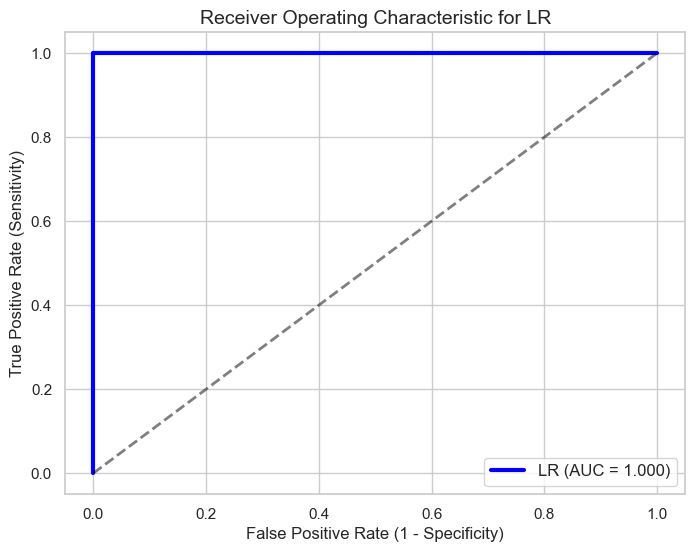

Confusion matrix of the model NB:
[[29  0]
 [ 4 47]]
True Negative of the model NB -> 29
False Positive of the model NB -> 0
False Negative of the model NB -> 4
True Positive of the model NB -> 47
Accuracy of the model NB -> 0.95
Misclassification rate of the model NB -> 0.050000000000000044
Precision of the model NB -> 1.0
Recall of the model NB -> 0.9215686274509803
F1 Measure of the model NB -> 0.9591836734693877
Specificity of the model NB -> 1.0
MCC of the model NB -> 0.8999240741724294
AUC of the model NB -> 1.0
Precision-Recall AUC of the model NB -> 1.0




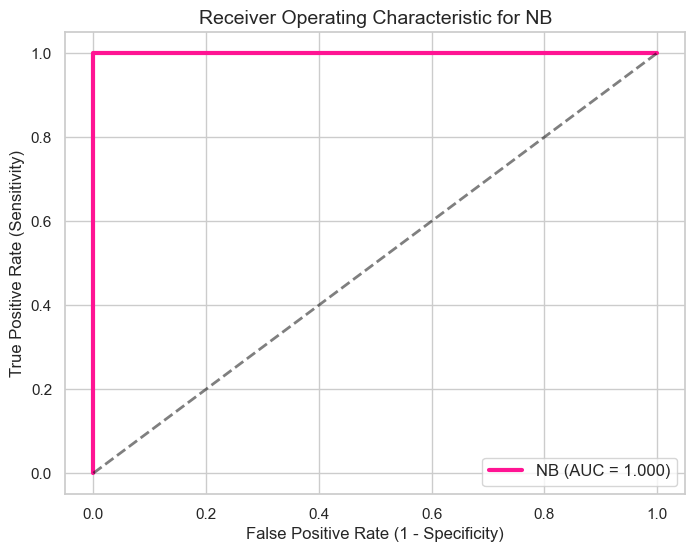

Confusion matrix of the model DT:
[[29  0]
 [ 1 50]]
True Negative of the model DT -> 29
False Positive of the model DT -> 0
False Negative of the model DT -> 1
True Positive of the model DT -> 50
Accuracy of the model DT -> 0.9875
Misclassification rate of the model DT -> 0.012499999999999956
Precision of the model DT -> 1.0
Recall of the model DT -> 0.9803921568627451
F1 Measure of the model DT -> 0.9900990099009901
Specificity of the model DT -> 1.0
MCC of the model DT -> 0.973505222533836
AUC of the model DT -> 0.9901960784313726
Precision-Recall AUC of the model DT -> 0.9928921568627451




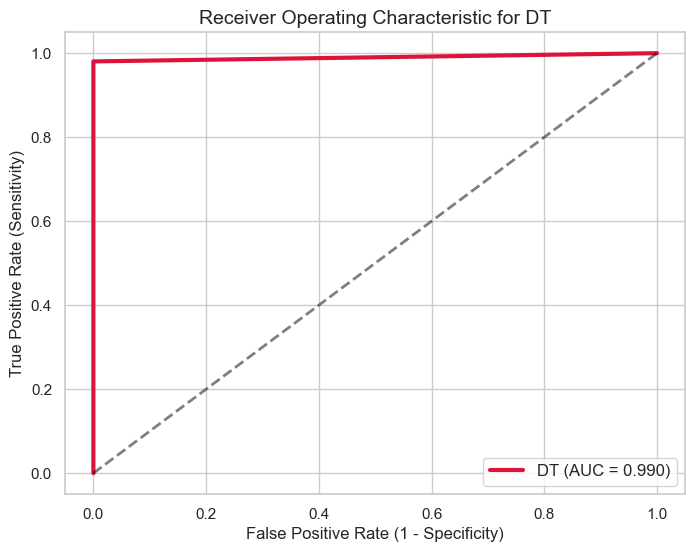

Confusion matrix of the model SVM:
[[29  0]
 [ 0 51]]
True Negative of the model SVM -> 29
False Positive of the model SVM -> 0
False Negative of the model SVM -> 0
True Positive of the model SVM -> 51
Accuracy of the model SVM -> 1.0
Misclassification rate of the model SVM -> 0.0
Precision of the model SVM -> 1.0
Recall of the model SVM -> 1.0
F1 Measure of the model SVM -> 1.0
Specificity of the model SVM -> 1.0
MCC of the model SVM -> 1.0
AUC of the model SVM -> 1.0
Precision-Recall AUC of the model SVM -> 1.0




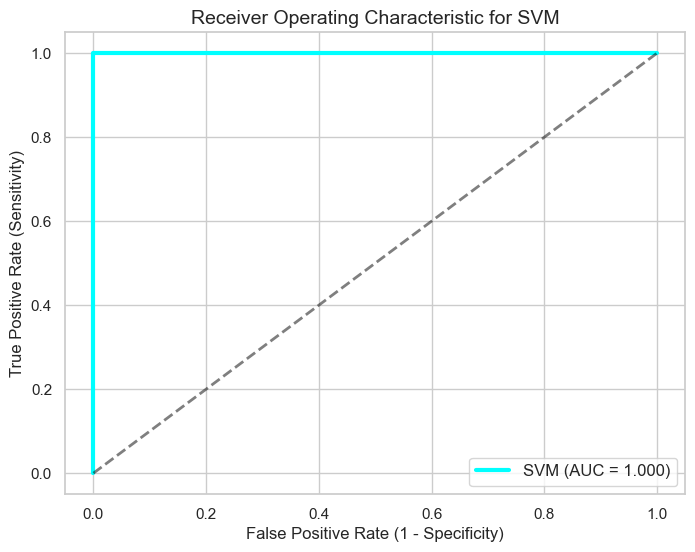

Confusion matrix of the model KNN:
[[29  0]
 [ 7 44]]
True Negative of the model KNN -> 29
False Positive of the model KNN -> 0
False Negative of the model KNN -> 7
True Positive of the model KNN -> 44
Accuracy of the model KNN -> 0.9125
Misclassification rate of the model KNN -> 0.08750000000000002
Precision of the model KNN -> 1.0
Recall of the model KNN -> 0.8627450980392157
F1 Measure of the model KNN -> 0.9263157894736842
Specificity of the model KNN -> 1.0
MCC of the model KNN -> 0.8336600666661518
AUC of the model KNN -> 0.9803921568627452
Precision-Recall AUC of the model KNN -> 0.9857843137254902




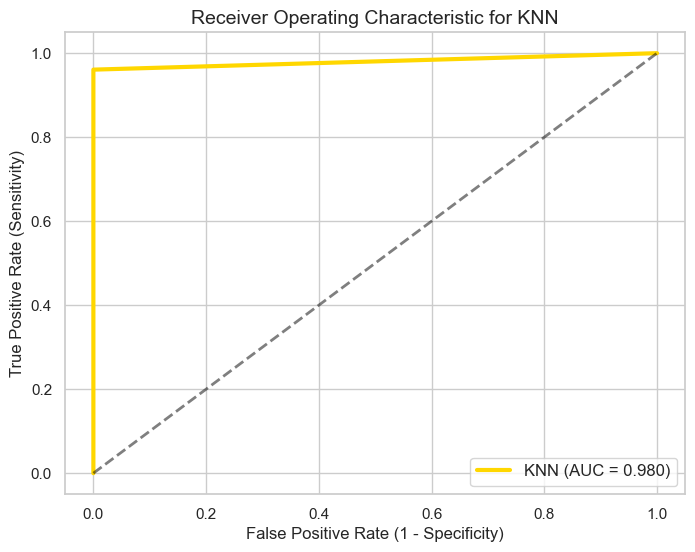

In [32]:
def eval_function_with_roc_plot():
    ml_curves = []

    for model in model_names:
        name = legend_names[model_names.index(model)]

        if name == "SVM":
            model_prediction = eval(f"model_{model}.predict(test_data)")
            model_proba = eval(f"model_{model}.decision_function(test_data)")
        else:
            model_prediction = eval(f"model_{model}.predict(test_data)")
            model_proba = eval(f"model_{model}.predict_proba(test_data)[:, 1]")

        model_cm = confusion_matrix(test_labels, model_prediction)
        tn, fp, fn, tp = model_cm.ravel()

        model_accuracy = accuracy_score(test_labels, model_prediction)
        model_misclassification = 1 - model_accuracy
        model_precision = precision_score(test_labels, model_prediction)
        model_recall = recall_score(test_labels, model_prediction)
        model_f1 = f1_score(test_labels, model_prediction)
        model_specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
        model_mcc = matthews_corrcoef(test_labels, model_prediction)

        # ROC Curve and AUC
        model_fpr, model_tpr, _ = roc_curve(test_labels, model_proba)
        model_auc = auc(model_fpr, model_tpr)

        # Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(test_labels, model_proba)
        model_pr_auc = average_precision_score(test_labels, model_proba)

        # Print metrics
        print(f"Confusion matrix of the model {name}:\n{model_cm}")
        print(f'True Negative of the model {name} -> {tn}')
        print(f'False Positive of the model {name} -> {fp}')
        print(f'False Negative of the model {name} -> {fn}')
        print(f'True Positive of the model {name} -> {tp}')
        print(f"Accuracy of the model {name} -> {model_accuracy}")
        print(f"Misclassification rate of the model {name} -> {model_misclassification}")
        print(f"Precision of the model {name} -> {model_precision}")
        print(f"Recall of the model {name} -> {model_recall}")
        print(f"F1 Measure of the model {name} -> {model_f1}")
        print(f"Specificity of the model {name} -> {model_specificity}")
        print(f"MCC of the model {name} -> {model_mcc}")
        print(f"AUC of the model {name} -> {model_auc}")
        print(f"Precision-Recall AUC of the model {name} -> {model_pr_auc}")
        print("\n")

        # Plot ROC Curve
        plt.figure(figsize=(8, 6))
        plt.plot(model_fpr, model_tpr, color=colors_names[model_names.index(model)], lw=3,
                 label=f'{name} (AUC = {model_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2, alpha=0.5)
        plt.legend(loc='lower right', fontsize=12)
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title(f'Receiver Operating Characteristic for {name}', fontsize=14)
        plt.show()

        # Save metrics to CSV
        csv_filename = f"models/{name}_metrics.csv"
        with open(csv_filename, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Metric', 'Value'])
            csv_writer.writerow(['True Negative', tn])
            csv_writer.writerow(['False Positive', fp])
            csv_writer.writerow(['False Negative', fn])
            csv_writer.writerow(['True Positive', tp])
            csv_writer.writerow(['Accuracy', model_accuracy])
            csv_writer.writerow(['Misclassification rate', model_misclassification])
            csv_writer.writerow(['Precision', model_precision])
            csv_writer.writerow(['Recall', model_recall])
            csv_writer.writerow(['F1 Measure', model_f1])
            csv_writer.writerow(['Specificity', model_specificity])
            csv_writer.writerow(['MCC', model_mcc])
            csv_writer.writerow(['AUC', model_auc])
            csv_writer.writerow(['Precision-Recall AUC', model_pr_auc])

        # Append to respective lists
        if name in lml_names:
            ml_curves.append([model_fpr, model_tpr, colors_names[model_names.index(model)], name, model_auc])
    
    return ml_curves

ml_c = eval_function_with_roc_plot()

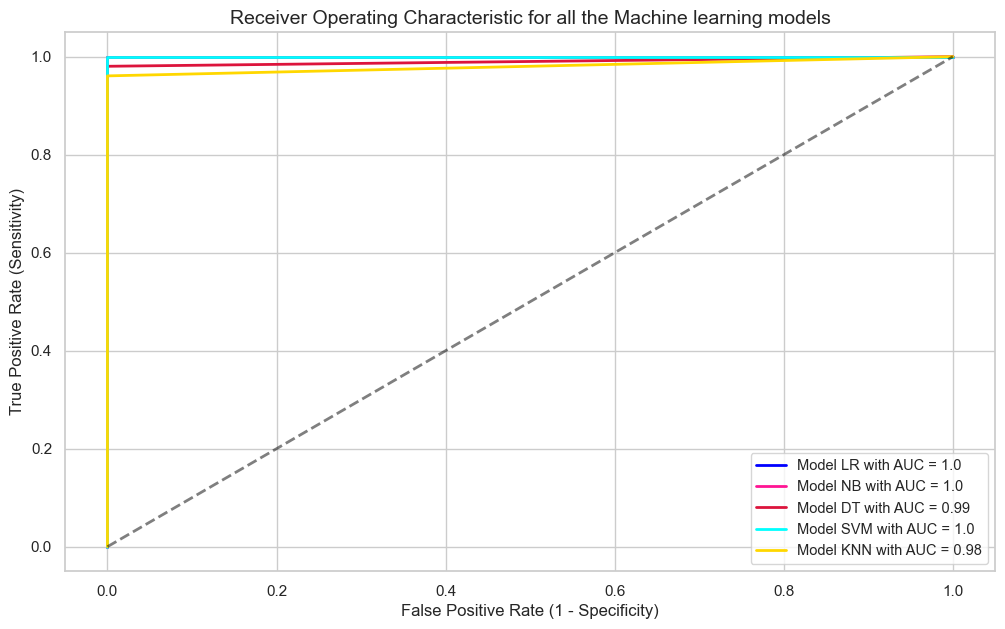

In [33]:
roc_curves = [ml_c]
names = ["Machine"]

for i in range(len(roc_curves)):
    plt.figure(figsize=(12, 7))
    for j in range(len(roc_curves[i])):
        plt.plot(roc_curves[i][j][0], roc_curves[i][j][1], color=roc_curves[i][j][2], lw=2, label=f'Model {roc_curves[i][j][3]} with AUC = {round(roc_curves[i][j][4], 2)}')

    plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2, alpha=0.5)

    # Customize legend position
    plt.legend(loc = 'lower right', fontsize=10.5)

    # Add labels and title
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(f'Receiver Operating Characteristic for all the {names[i]} learning models', fontsize=14)

    # Show the plot
    plt.show()

### Feature Importance using shap

In [34]:
ml_models = {'lr': model_lr, 'nb': model_nb, 'dt': model_dt, 'svm': model_svm, 'knn': model_knn}

In [35]:
shap_values_dict = {}
for name, model in ml_models.items():
    if name in ['nb', 'knn']:
        explainer = shap.KernelExplainer(model.predict, train_data)
        shap_values = explainer.shap_values(test_data)
    elif name == "dt":
        explainer = shap.TreeExplainer(model, train_data)
        shap_values = explainer.shap_values(test_data)
    else:
        explainer = shap.Explainer(model, train_data)
        shap_values = explainer(test_data)
    shap_values_dict[name] = shap_values

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [04:49<00:00,  3.61s/it]
Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [06:14<00:00,  4.68s/it]


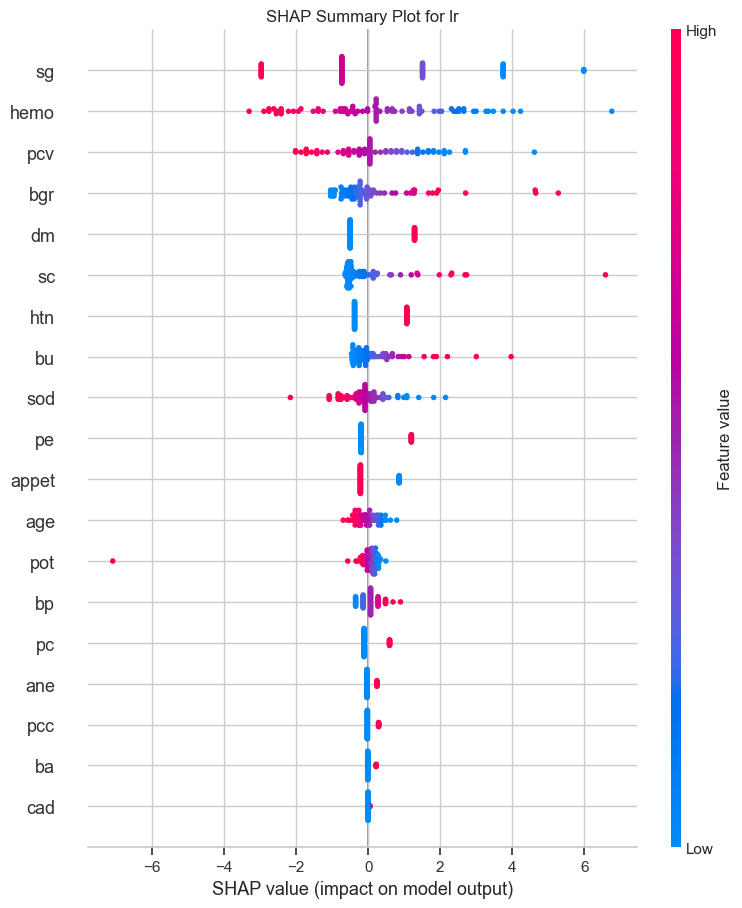

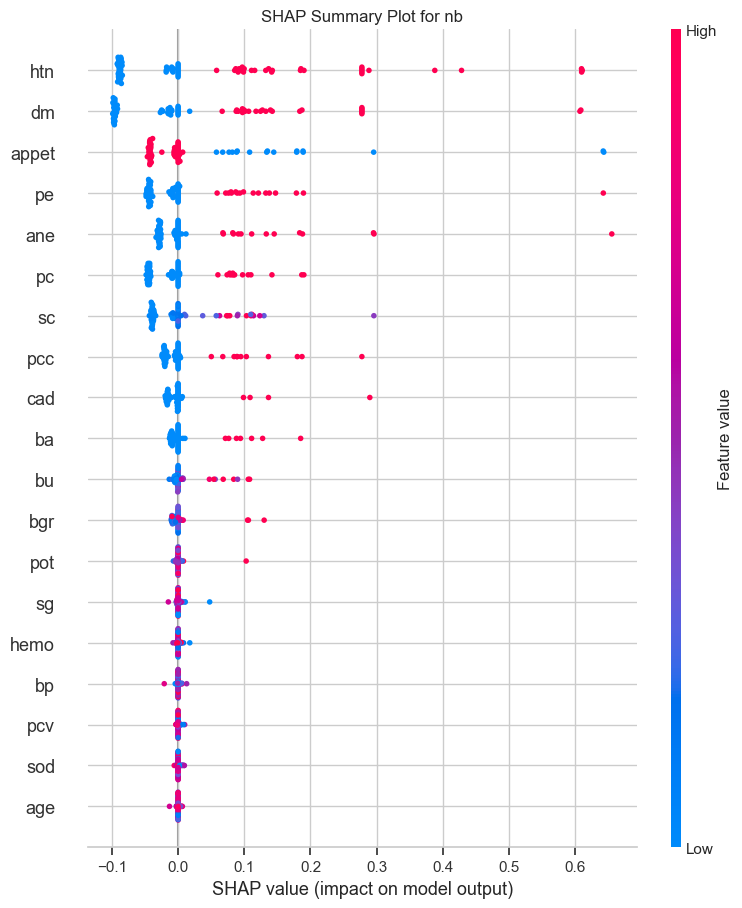

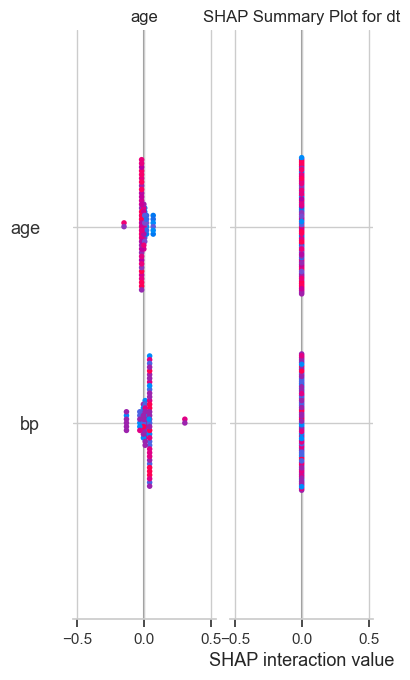

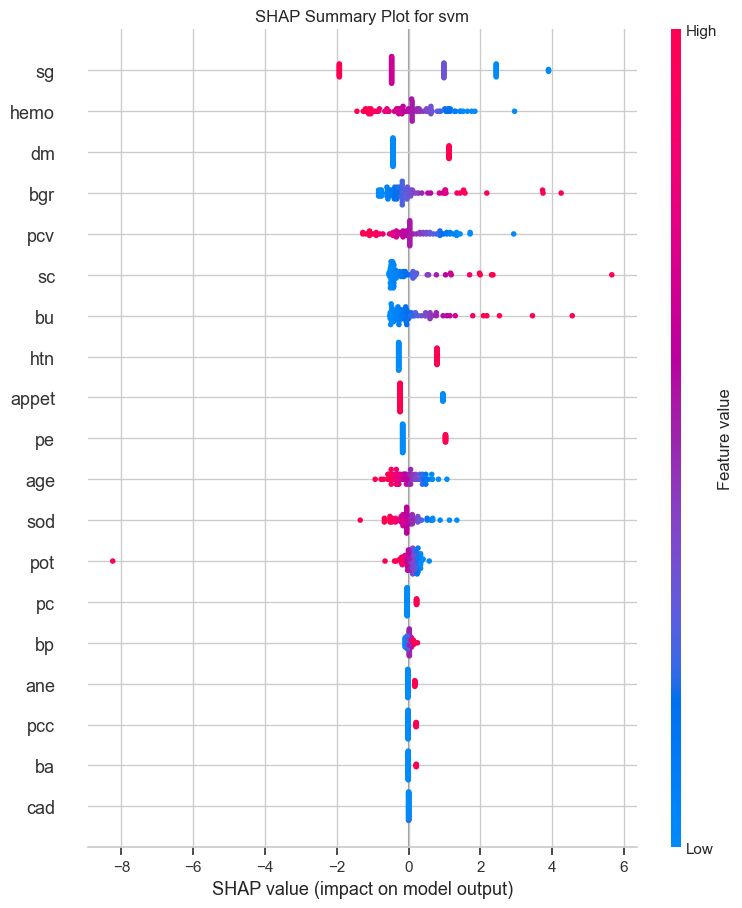

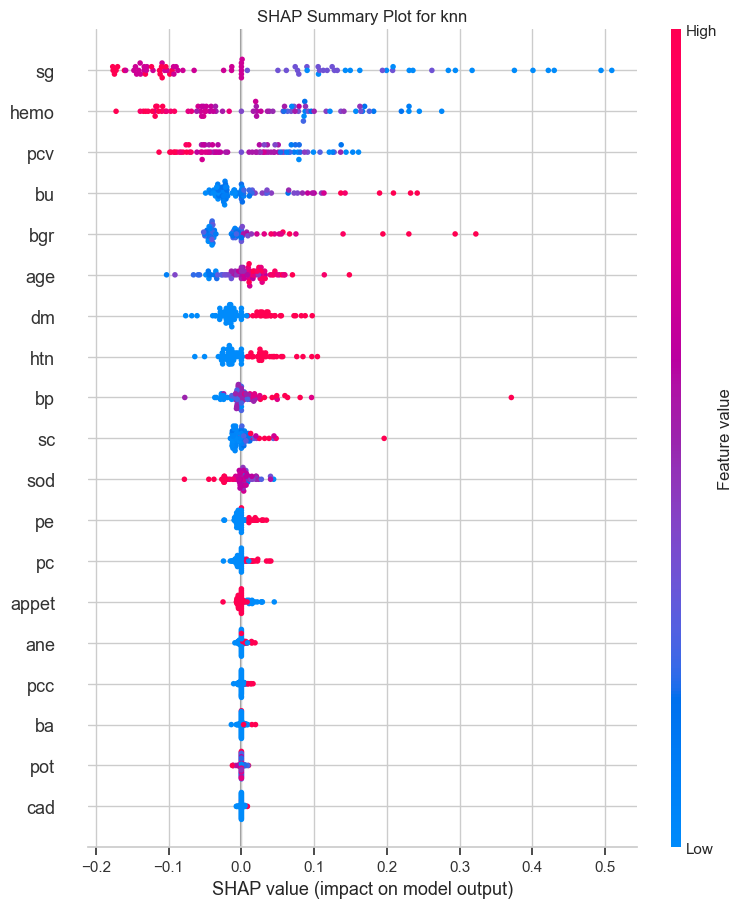

In [36]:
for name, shap_values in shap_values_dict.items():
    shap.summary_plot(shap_values, test_data, show=False)
    plt.title(f'SHAP Summary Plot for {name}')
    plt.show()

In [41]:
feature_importance_df = pd.DataFrame(index=train_data.columns)

for name, shap_values in shap_values_dict.items():
    if hasattr(shap_values, 'values'):
        feature_importance = np.abs(shap_values.values).mean(axis=0)
    else:
        feature_importance = np.abs(shap_values).mean(axis=0)
    if name in ["dt", "knn"]:
        break
    else:
        feature_importance_df[name] = feature_importance

feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(by='mean_importance', ascending=False)

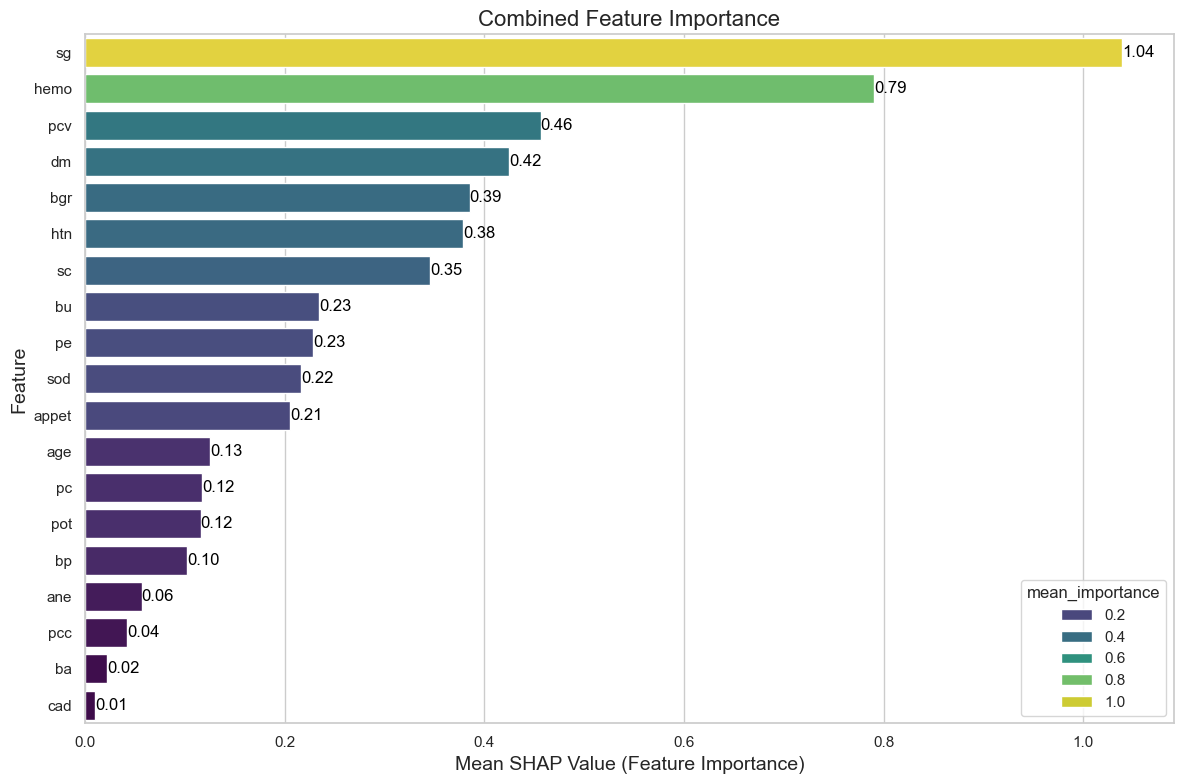

In [44]:
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance_df['mean_importance'], y=feature_importance_df.index, hue=feature_importance_df['mean_importance'], palette='viridis')
plt.title('Combined Feature Importance', fontsize=16)
plt.xlabel('Mean SHAP Value (Feature Importance)', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Annotate the bar plot with the importance values
for index, value in enumerate(feature_importance_df['mean_importance']):
    plt.text(value, index, f'{value:.2f}', color='black', ha="left", va="center")

plt.tight_layout()
plt.show()

In [45]:
# Save the best features to a CSV file
best_features = feature_importance_df.index.tolist()
best_features_df = pd.DataFrame(best_features, columns=['feature_name'])
best_features_df.to_csv('best_features.csv', index=False)